In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
! which jupyter

/home/abaumann/anaconda3/envs/cuda/bin/jupyter


In [3]:
import logging
import random
from functools import partial
from pathlib import Path
import pandas as pd
import numpy as np

import fire
import torch
from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.metrics import fbeta
from fastai.train import to_fp16
from learner import (OneHotCallBack, conll_f1, create_fp16_cb,
                     ner_loss_func, Conll_F1)
from ner_data import NerDataset, pad
from optimizer import BertAdam
from pytorch_pretrained_bert import BertForTokenClassification
from torch.utils.data import DataLoader
from fastai.torch_core import flatten_model

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


# Initialisation

Define Values for the Run

In [24]:
lang='eng'
ds_size=None
name='jpei'
batch_size:int=16
csvn = 'logs/eng-tune'+name+'.csv'
datapath = 'data/conll-2003-I/'
pretrain=False
pretrained_lm = 'pretrain/pytorch_fastai_model_bert-base-casedm_10.bin'

In [5]:
log_dir:str='logs'
lr:float=5e-5
epochs:int=1
trainset:str=datapath
devset:str=datapath
testset:str=datapath
max_seq_len:int=128
do_lower_case:bool=False
warmup_proportion:float=0.1
data_bunch_path:str='data/conll-2003/db'

In [6]:
bert_model = 'bert-base-cased' if lang=='eng' else 'bert-base-multilingual-cased'

## Dataset
Load the dataset and define a databunch

In [7]:
trainset += lang + '/train.txt'
devset += lang + '/dev.txt'
testset += lang + '/test.txt'

In [9]:
train_dl = DataLoader(
    dataset=NerDataset(trainset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad
)

dev_dl = DataLoader(
    dataset=NerDataset(devset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad
)

test_dl = DataLoader(
    dataset=NerDataset(testset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad
)

data = DataBunch(
    train_dl= train_dl,
    valid_dl= dev_dl,
    test_dl = test_dl,
    collate_fn=pad,
    path = Path(data_bunch_path)
)


data/conll-2003/eng/train.txt
lines 14041 sents 14041	style: x=s y=s

data/conll-2003/eng/dev.txt
lines 3250 sents 3250	style: x=s y=s

data/conll-2003/eng/test.txt
lines 3453 sents 3453	style: x=s y=s


## Model & Learner
define BERT model
define Learner object

In [11]:
def bert_layer_list(model):
    ms = torch.nn.ModuleList()

    flm = flatten_model(model)
    # embedding = [0:5] layer
    ms.append(torch.nn.ModuleList(flm[0:5]))
    # encoder (12 layers) = [5:16] [16:27] ... [126:136]
    for i in range(5, 137, 11):
        ms.append(torch.nn.ModuleList(flm[i: i+11]))
    # pooling layer = [137:139]
    ms.append(torch.nn.ModuleList(flm[-4:-2]))
    ms.append(torch.nn.ModuleList(flm[-2:]))
    # head = [-2:]
    return ms

In [12]:
model = BertForTokenClassification.from_pretrained(bert_model, num_labels=10, cache_dir='bertm')

In [13]:
if pretrain:
    model.bert.load_state_dict(torch.load(pretrained_lm))

In [14]:
model = torch.nn.DataParallel(model)
num_layers = len(bert_layer_list(model))
num_layers

15

In [15]:
optim = BertAdam
loss_fun = ner_loss_func

In [16]:
metrics = [Conll_F1()]

In [17]:
learn = Learner(data, model, optim,
                    loss_func=loss_fun,
                    metrics=metrics,
                    true_wd=False,
                    layer_groups= bert_layer_list(model),
                    path='learn',
                    )

In [18]:
batch_size

16

In [19]:
lang

'eng'

In [30]:
chtw = ([3e-5]*14+[3e-4], 0)
chtw2 = ([3e-5]*2 +[5e-5]*3+[1e-4]*3+[3e-4]*3+[5e-4]*3 +[5e-3], 0)

[3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 3e-05,
 5e-05]

In [20]:
def test_lrs(stage, all_lrs, runs=2):
    res = []
    for i,lrs in enumerate(all_lrs):
        lrs,lrm = lrs
        print(i, lrm, lrs)
        i_res = {'lrs': lrs, 'lrm':lrm, 'f1s':[], 'vals':[], 'train':[]}
        for _ in range(runs):
            learn.load(stage)
            learn.fit_one_cycle(1, lrs, moms=(0.8,0.7))
            
            i_res['f1s'].append(learn.recorder.metrics[0][0])
            i_res['vals'].append(learn.recorder.val_losses[0])
            i_res['train'].append(learn.recorder.losses)
        i_res['val'] = sum(i_res['vals'])/runs
        i_res['f1'] = sum(i_res['f1s'])/runs
        res.append(i_res)
    return res

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


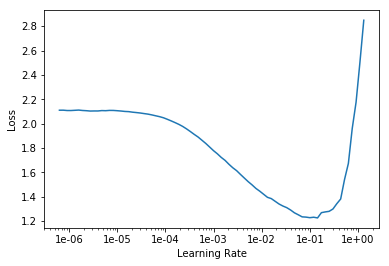

In [21]:
# learn.freeze()
# learn.save(f'{name}x')
# learn.lr_find()
# learn.recorder.plot()

In [43]:
# lrs = [
#     1e-02, 2e-02, 8e-3, 5e-3, 5e-4,
# ]
# lrs = [(i, 1) for i in lrs]
# stage1 = test_lrs(f'{name}x', lrs)

0 1 0.01


epoch,train_loss,valid_loss,Total F1,time


KeyboardInterrupt: 

In [27]:
# df = pd.DataFrame(stage1).sort_values(by=['f1', 'val'],ascending=[False, True])
# df.to_csv(csvn, mode='a')
# df

,f1,f1s,lrm,lrs,train,val,vals
2,0.873526,"[0.875592416561694, 0.8714589230127644]",1,0.008,"[[tensor(2.1103), tensor(1.9529), tensor(1.762...",0.122910,"[0.12528615, 0.1205342]"
3,0.870685,"[0.869699672411258, 0.8716701270587013]",1,0.005,"[[tensor(2.1416), tensor(2.0134), tensor(1.872...",0.126849,"[0.12991036, 0.12378812]"
0,0.870211,"[0.8718372156604313, 0.8685855840228345]",1,0.010,"[[tensor(2.1820), tensor(1.9064), tensor(1.698...",0.128747,"[0.12960954, 0.12788524]"
1,0.868124,"[0.8678646929460414, 0.8683840744413774]",1,0.020,"[[tensor(2.1505), tensor(1.7335), tensor(1.451...",0.154693,"[0.15259233, 0.1567946]"


In [25]:
# learn.load(f'{name}x')
# lr0 = df.iloc[0]['lrs']
# learn.fit_one_cycle(1, lr0, moms=(0.8,0.7))
# #learn.fit_one_cycle(1, 0.008, moms=(0.8,0.7))

epoch,train_loss,valid_loss,Total F1,time
0,0.209884,0.160633,0.874354,03:52


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


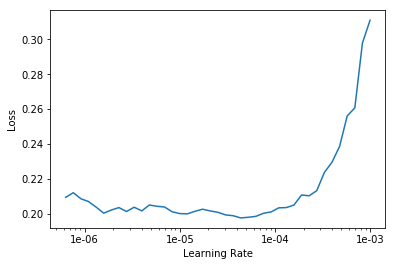

In [27]:
# learn.freeze_to(-3)
# learn.save(f'{name}x3')
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
# lrs =[]
# lrms = [2.6, 1.6, 1]
# lrs.append(chtw2)
# lrs.append(chtw)
# for lrm in lrms:
#     div = (lrm**num_layers)
#     lrs.append((learn.lr_range(slice(2e-4/div, 2e-4)),lrm))
#     lrs.append((learn.lr_range(slice(3e-4/div, 3e-4)),lrm))
#     lrs.append((learn.lr_range(slice(5e-4/div, 5e-4)),lrm))
#     if lrm!=1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
# stage2 = test_lrs(f'{name}x3', lrs)

In [ ]:
# df = pd.DataFrame(stage2).sort_values(by=['f1', 'val'],ascending=[False, True])
# df.to_csv(csvn, mode='a')
# df

In [27]:
# learn.load(f'{name}x3')
# # lrs = learn.lr_range(slice(1e-5/(2.6**14),1e-5))
# learn.fit_one_cycle(1,df.iloc[0]['lrs'], moms=(0.8,0.7))

epoch,train_loss,valid_loss,Total F1,time
0,0.029114,0.051450,0.928314,05:49


In [ ]:
# learn.freeze_to(-6)
# learn.save(f'{name}x6')
# learn.lr_find()
# learn.recorder.plot()


In [ ]:
# lrs =[]
# lrms = [2.6, 1.6, 1]
# lrs.append(chtw)
# lrs.append(chtw2)
# for lrm in lrms:
#     div = (lrm**num_layers)
#     if lrm!= 1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
#     lrs.append((learn.lr_range(slice(3e-4/div, 3e-4)),lrm))
#     lrs.append((learn.lr_range(slice(1e-4/div, 1e-4)),lrm))
#     lrs.append((learn.lr_range(slice(5e-5/div, 5e-5)),lrm))
# stage3 = test_lrs(f'{name}x6', lrs)

In [ ]:
# df = pd.DataFrame(stage3).sort_values(by=['f1', 'val'],ascending=[False, True])
# df.to_csv(csvn, mode='a')
# df

In [ ]:
# learn.load(f'{name}x6')
# learn.fit_one_cycle(1, df.iloc[0]['lrs'], moms=(0.8, 0.7))

In [ ]:
# learn.freeze_to(-12)
# learn.save(f'{name}x12')
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
lrs =[]
lr0 = 0.01
lrms = [2.6, 1.6, 1] # 2.6,
lrs.append(chtw)
lrs.append(chtw2)
for lrm in lrms:
    div = (lrm**num_layers)
    if lrm!= 1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
    lrs.append((learn.lr_range(slice(3e-4/div, 3e-4)),lrm))
    lrs.append((learn.lr_range(slice(1e-4/div, 1e-4)),lrm))
    lrs.append((learn.lr_range(slice(5e-5/div, 5e-5)),lrm))
print(lrs)

In [ ]:
stage12 = test_lrs(f'{name}x12', lrs)

In [ ]:
df = pd.DataFrame(stage12).sort_values(by=['f1', 'val'],ascending=[False, True])
df.to_csv(csvn, mode='a')
df

In [ ]:
learn.load(f'{name}x12')
learn.fit_one_cycle(1, df.iloc[0]['lrs'], moms=(0.8, 0.7))
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.save(f'{name}x15')
learn.lr_find()
learn.recorder.plot()

In [ ]:
lrs =[]
lrms = [2.6, 1.6, 1]#2.6, 
lrs.append(chtw)
lrs.append(chtw2)
for lrm in lrms:
    div = (lrm**num_layers)
    if lrm!= 1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
    lrs.append((learn.lr_range(slice(1e-4/div, 1e-4)),lrm))
    lrs.append((learn.lr_range(slice(2e-5/div, 2e-5)),lrm))
    lrs.append((learn.lr_range(slice(3e-5/div, 3e-5)),lrm))
    lrs.append((learn.lr_range(slice(5e-5/div, 5e-5)),lrm))

In [ ]:
stage15 = test_lrs(f'{name}x15', lrs)

In [ ]:
df = pd.DataFrame(stage15).sort_values(by=['f1', 'val'],ascending=[False, True])
df.to_csv(csvn, mode='a')
df

In [ ]:
learn.load(f'{name}x15')
learn.fit_one_cycle(1, df.iloc[0]['lrs'], moms=(0.8, 0.7))
learn.recorder.plot_losses()

In [ ]:
learn.recorder.metrics
learn.recorder.val_losses
learn.recorder.losses

In [ ]:
met = learn.validate(test_dl, metrics=metrics)
met

In [ ]:
df = pd.DataFrame(met)
df.to_csv(csvn, mode='a')
df